In [1]:
import os
import math
import torch
import numpy as np
import pandas as pd
import seaborn as sns

import  matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration,  DataCollatorWithPadding
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 1. 데이터 전처리

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = T5Tokenizer.from_pretrained("google/t5-v1_1-large")
#model_small = T5ForConditionalGeneration.from_pretrained("google/t5-v1_1-small", output_hidden_states=True)
# model_large = T5ForConditionalGeneration.from_pretrained("google/t5-v1_1-xxl", output_hidden_states=True)#, output_attentions=True)
model_small = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small", output_hidden_states=True).to(device)
# f_model_large = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xxl", output_hidden_states=True)

#model_small = T5ForConditionalGeneration.from_pretrained("declare-lab/flan-alpaca-xxl", output_hidden_states=True)
# model_small = T5ForConditionalGeneration.from_pretrained("declare-lab/flan-alpaca-xl", output_hidden_states=True)

In [5]:
model_small

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [3]:
dataset = load_dataset('HuggingFaceH4/databricks_dolly_15k')
df  = pd.DataFrame(dataset['train'])
df.groupby('category').count()

Found cached dataset parquet (/home/uj-user/.cache/huggingface/datasets/HuggingFaceH4___parquet/HuggingFaceH4--databricks_dolly_15k-6252f3495e7d2b9d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

,instruction,input,output
category,,,
brainstorming,1768,1768,1768
classification,2136,2136,2136
closed_qa,1823,1823,1823
creative_writing,711,711,711
general_qa,2191,2191,2191
information_extraction,1512,1512,1512
open_qa,3611,3611,3611
summarization,1263,1263,1263


In [4]:
# 카테고리 전처리 후 데이터셋으로 변경
prep_df = df[df['category']!='']
prep_df['category'] = prep_df['category'].apply(lambda x: 'Commonsense/logic' if x=="Common Sense / Logic" else x)
prep_df = prep_df.sort_values('category')

prep_data = Dataset.from_pandas(prep_df, preserve_index=False)
dataset = DatasetDict({'train':prep_data})
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output'],
        num_rows: 15015
    })
})

In [5]:
def preprocess_function(example):
    return tokenizer(example["instruction"], truncation=True, padding=False, max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets['train'] = tokenized_datasets['train'].rename_column("input_ids", "encoder_input_ids")
tokenized_datasets['train'] = tokenized_datasets['train'].remove_columns(['attention_mask'])

def preprocess_func(example):
    return tokenizer(example["output"], truncation=True, padding=False)

tokenized_datasets = tokenized_datasets.map(preprocess_func, batched=True)
tokenized_datasets['train'] = tokenized_datasets['train'].rename_column("input_ids", "decoder_input_ids")
#tokenized_datasets['train'] = tokenized_datasets['train'].remove_columns(['id', 'source', 'category', 'subcategory', 'prompt', 'input', 'output'])

tokenized_datasets.set_format("torch")
tokenized_datasets

Map:   0%|          | 0/15015 [00:00<?, ? examples/s]

Map:   0%|          | 0/15015 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output', 'encoder_input_ids', 'decoder_input_ids', 'attention_mask'],
        num_rows: 15015
    })
})

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch_size = 2

encoder_datasets = tokenized_datasets['train'].remove_columns(['category', 'instruction', 'input', 'output', 'attention_mask', 'decoder_input_ids'])
decoder_datasets = tokenized_datasets['train'].remove_columns(['category', 'instruction', 'input', 'output', 'attention_mask', 'encoder_input_ids'])

encoder_datasets = encoder_datasets.rename_column('encoder_input_ids','input_ids')
decoder_datasets = decoder_datasets.rename_column('decoder_input_ids','input_ids')

encoder_dataloader = DataLoader(encoder_datasets, batch_size=batch_size, shuffle=False, collate_fn=data_collator, drop_last=True)
decoder_dataloader = DataLoader(decoder_datasets, batch_size=batch_size, shuffle=False, collate_fn=data_collator, drop_last=True)

In [7]:
encoder_datasets

Dataset({
    features: ['input_ids'],
    num_rows: 15015
})

# 2. 모델 Inference

In [8]:
def _get_model_hidden_states(outputs, encoder_style:str):
    if encoder_style=="encoder":
        hs = outputs.encoder_hidden_states
    elif encoder_style=="decoder":
        hs = outputs.decoder_hidden_states#.detach().cpu().numpy()
    else:
        print('Error: model style not properly selected.')
    return hs

def _get_layer_hidden_states(hs, layer_style:str):
    if layer_style=="first":
        hs = hs[0].detach().cpu().numpy()
    elif layer_style=="last":
        hs = hs[-1].detach().cpu().numpy()
    elif layer_style=="avg":
        #hs = np.mean(hs[:].detach().cpu().numpy(), axis=0)
        hs = torch.mean(torch.stack(hs, axis=0), axis=0).detach().cpu().numpy()
    elif layer_style=="avg_last4":
        hs = torch.mean(torch.stack(hs[-4:], axis=0), axis=0).detach().cpu().numpy()
        #hs = np.mean(hs[-4:], axis=0)
    else:
        print('Error: layer style not properly selected.')
    return hs

def _get_element_hidden_states(hs, element_style:str):
    if element_style=="cls":
        hs = hs[:, 0, :]
    elif element_style=="last":
        hs = hs[:, -1, :]
    elif element_style=="avg":
        hs = np.mean(hs, axis=1)
    else:
        print('Error: layer style not properly selected.')
    return hs

# encoderwise, layerwise, elementwise
def get_hidden_states(outputs, encoder_style:str, layer_style:str, element_style:str):
    """ 
    model : ['encoder', 'decoder']
    layer_style : ['first', 'last', 'avg', avg_last4]
    element_style : ['cls', 'last', 'avg', ]
    """
    hs = _get_model_hidden_states(outputs, encoder_style)
    layer_hs = _get_layer_hidden_states(hs, layer_style)
    #print(layer_hs.shape)
    #squeeze_hs = np.squeeze(layer_hs, axis=0)
    element_hs = _get_element_hidden_states(layer_hs, element_style) # optional use for only one embedding
    return element_hs

def get_dataset_hidden_states(encoder_style:str, layer_style:str, element_style:str):
    hs_list = []
    for inputs, labels in zip(encoder_dataloader, decoder_dataloader):
        input_ids = inputs.input_ids.to(device="cuda")
        #print(input_ids.shape)
        labels = labels.input_ids.to(device="cuda")
        outputs = model_small(input_ids=input_ids, labels=labels)

        hs = get_hidden_states(outputs, encoder_style=encoder_style, layer_style=layer_style, element_style=element_style)
        hs_list.append(hs)
        #torch.cuda.empty_cache()
        #print(hs.shape)
    return np.array(hs_list).reshape([-1, hs.shape[-1]])

def get_category_group_hidden_states(encoder_style:str, layer_style:str, element_style:str, category:str):
    hs_list = []
    for i, batch in enumerate(tokenized_datasets['train']):
        if batch['category']==category:
            input_ids = torch.unsqueeze(batch['encoder_input_ids'], 0).to(device="cuda")
            labels = torch.unsqueeze(batch['decoder_input_ids'], 0).to(device="cuda")
            outputs = model_small(input_ids=input_ids, labels=labels)
            hs = get_hidden_states(outputs, encoder_style=encoder_style, layer_style=layer_style, element_style=element_style)
            hs_list.append(hs)
    return np.mean(np.array(hs_list), axis=0)



# hs_list = get_hidden_states(outputs, encoder_style='encoder', layer_style='last', element_style='last')
#hs_list = get_dataset_hidden_states(encoder_style='encoder', layer_style='last', element_style='cls')

# hs_enc_last_cls = get_dataset_hidden_states(encoder_style='encoder', layer_style='last', element_style='cls')
# hs_enc_last_cls.shape

In [9]:
input_ids = tokenizer("Suggest a related search term to watermelon", return_tensors="pt").input_ids.to(device)
labels = tokenizer("Suggest a related search term to watermelon", return_tensors="pt").input_ids.to(device)
outputs = model_small(input_ids=input_ids, labels=labels)
outputs.keys()
print(len(outputs.decoder_hidden_states))
print(outputs.decoder_hidden_states[0].shape)

9
torch.Size([1, 13, 512])


# 시각화

In [10]:
### 1. 각 카테고리별 Embedding 평균[]
### 0. 각 문장별 Embedding [enc, dec], [first, last, avg, last4, intermed4]

In [11]:
def visualize_batch_embedding(hs, output_name='output.png', figsize=(10,20), text=None):
    # (273, 512) # batch, embedding_dim
    fig, axs = plt.subplots(math.ceil(len(hs)/2), 2, figsize=figsize)
    axs = axs.ravel()
    for i in range(len(hs)):
        img = axs[i].imshow(np.expand_dims(hs[i], axis=0),  aspect='150', cmap='Greys')
        axs[i].set_title(tokenized_datasets['train']['category'][i], fontsize=10)
        axs[i].axis('off')
        #plt.colorbar(img)
        if text:
            axs[i].set_title(text[i], fontsize=10)
    fig.savefig(output_name, dpi=300, bbox_inches='tight')
        
def visualize_embedding(hs, text=''):
    # input: (512,)
    plt.imshow(np.expand_dims(np.mean(hs, axis=0), 0),  aspect='30', cmap='Greys')
    plt.axis('off')
    plt.title(text)

In [12]:
output_img_dir = 't5_image'
os.makedirs(output_img_dir, exist_ok=True)

cat_emb_list = []
category_list = prep_df['category'].value_counts().keys().tolist()
for cat in category_list:
    print(cat)
    cat_emb = get_category_group_hidden_states(encoder_style='encoder', layer_style='last', element_style='last', category=cat)
    cat_emb_list.append(np.squeeze(cat_emb))

cat_emb_arr = np.array(cat_emb_list)
print(cat_emb_arr.shape)

open_qa
general_qa
classification
closed_qa
brainstorming
information_extraction
summarization
creative_writing
(8, 512)


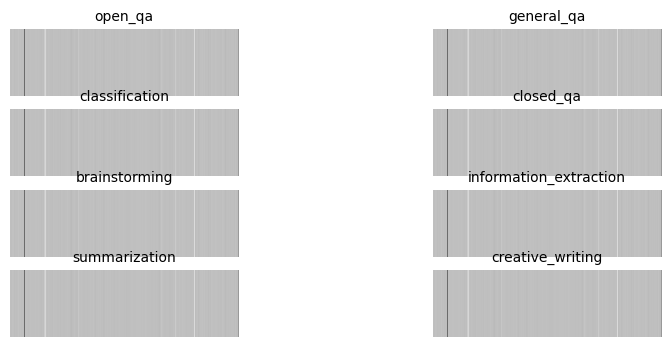

In [13]:
visualize_batch_embedding(cat_emb_arr, f'./{output_img_dir}/cat_emb.png', (10,4), category_list)

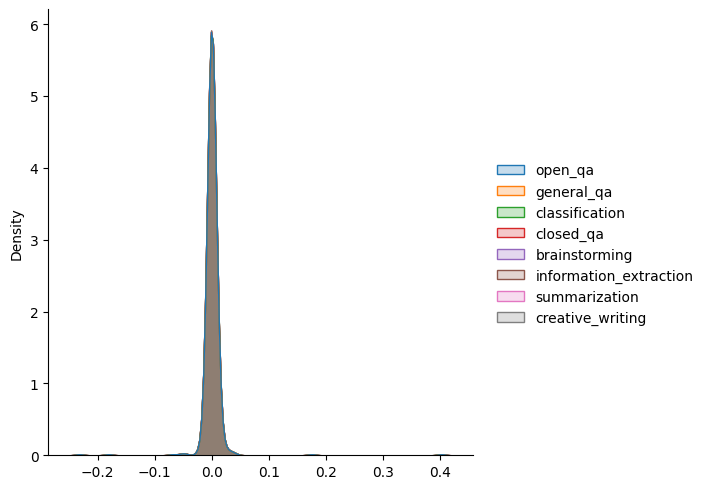

In [14]:
df_cat_emb = pd.DataFrame(cat_emb_arr.T, columns=category_list)
sns.displot(df_cat_emb, kind="kde", fill=True)#, hue="512")

In [15]:
hs_enc_last_last = get_dataset_hidden_states(encoder_style='encoder', layer_style='last', element_style='cls')
hs_enc_last_last.shape

(15014, 512)

In [16]:
hs_enc_last_last.reshape([-1, 1024]).shape

(7507, 1024)

In [17]:
tokenized_datasets['train']

Dataset({
    features: ['category', 'instruction', 'input', 'output', 'encoder_input_ids', 'decoder_input_ids', 'attention_mask'],
    num_rows: 15015
})

,component 0,component 1,label
0,0.837027,-0.140660,brainstorming
1,-0.987864,-0.410728,brainstorming
2,0.262044,0.380563,brainstorming
3,0.757619,0.181589,brainstorming
4,1.082171,-0.326959,brainstorming
...,...,...,...
15009,0.769453,0.154300,summarization
15010,0.603969,0.132925,summarization
15011,-0.581892,0.567165,summarization
15012,0.575340,0.434599,summarization


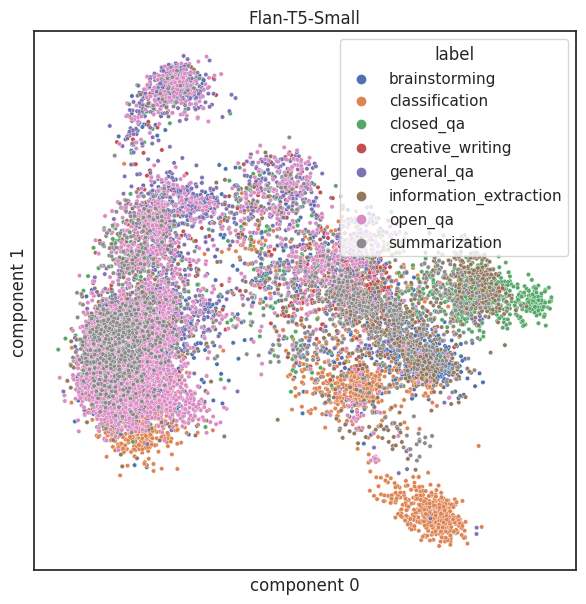

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

n_components =2 
pca = PCA(n_components =n_components, random_state=0)
#pca = TSNE(n_components = n_components, random_state=0)
pca_np = pca.fit_transform(hs_enc_last_last)

dataset_len = len(tokenized_datasets['train'])
data_length = dataset_len - dataset_len%batch_size

pca_df = pd.DataFrame(pca_np, columns = ['component 0', 'component 1'])
pca_df['label'] = tokenized_datasets['train']['category'][:data_length]
pca_df

sns.set(rc={'figure.figsize':(7,7)})
sns.set_style("white")

ax = sns.scatterplot(x='component 0', y='component 1', hue='label', data=pca_df, s=10)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.title('Flan-T5-Small')
plt.savefig('./t5_pca_image/flan-small-enc.svg')

In [20]:
hs_dec_last_last = get_dataset_hidden_states(encoder_style='decoder', layer_style='last', element_style='last')
hs_dec_last_last.shape

(15014, 512)

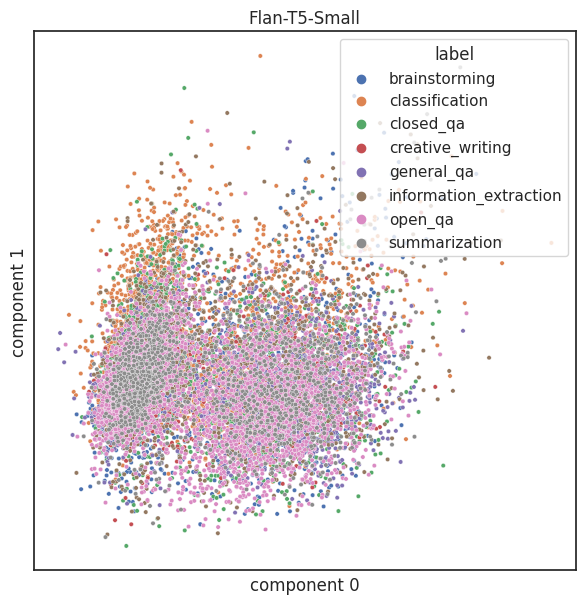

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

n_components =2 
pca = PCA(n_components =n_components, random_state=0)
#pca = TSNE(n_components = n_components, random_state=0)
pca_np = pca.fit_transform(hs_dec_last_last)

dataset_len = len(tokenized_datasets['train'])
data_length = dataset_len - dataset_len%batch_size

pca_df = pd.DataFrame(pca_np, columns = ['component 0', 'component 1'])
pca_df['label'] = tokenized_datasets['train']['category'][:data_length]
pca_df

sns.set(rc={'figure.figsize':(7,7)})
sns.set_style("white")

ax = sns.scatterplot(x='component 0', y='component 1', hue='label', data=pca_df, s=10)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.title('Flan-T5-Small')
plt.savefig('./t5_pca_image/flan-small-dec.svg')


In [22]:
# category_name = np.expand_dims(tokenized_datasets['train']['category'], axis=1)
# data = np.concatenate((cat_emb_arr, category_name), axis=1)
# df_cat_emb = pd.DataFrame(data)
# df_cat_emb

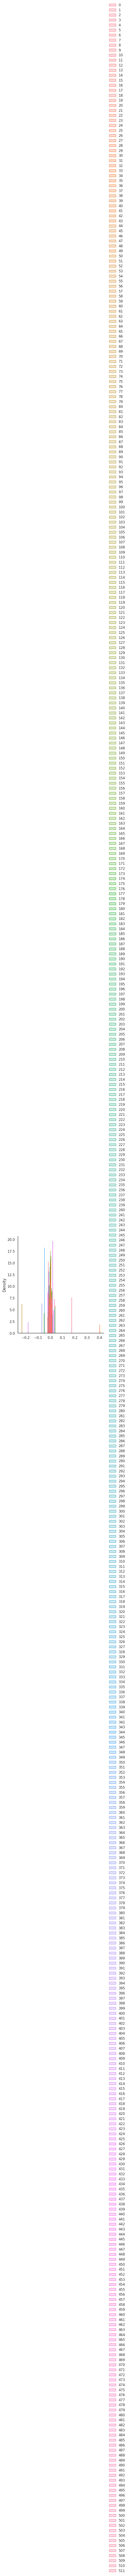

In [23]:
# df_cat_emb = pd.DataFrame(np.expand_dims(cat_emb_arr[0:1], axis=0))
df_cat_emb = pd.DataFrame(cat_emb_arr)
sns.displot(df_cat_emb, kind="kde", fill=True)#, hue="512")

In [24]:
hs_enc_last_last

array([[ 0.04133518, -0.23672783, -0.01369734, ...,  0.10593896,
        -0.1100978 , -0.11723502],
       [ 0.03752244, -0.20380588, -0.06350379, ..., -0.00441434,
        -0.02884506, -0.20922084],
       [-0.08290878, -0.09895817,  0.12431976, ..., -0.02051222,
        -0.06927112, -0.07683223],
       ...,
       [-0.22510158, -0.18826199,  0.10579851, ...,  0.15831724,
        -0.17244712, -0.18802944],
       [-0.00043566, -0.00601151, -0.00611315, ..., -0.00865821,
        -0.00525209,  0.1604533 ],
       [ 0.02453025, -0.05328338, -0.09507182, ...,  0.08130442,
         0.11748142, -0.17786433]], dtype=float32)

visualize_batch_embedding(hs_enc_last_last, f"./{output_img_dir}/hs_enc_last_cls.png", (10,25))

In [25]:
# model_style =  ['encoder', 'decoder']
# layer_style = ['first', 'last', 'avg', 'avg_last4']
# element_style = ['cls', 'last', 'avg', ]

# for model_s in model_style:
#     for layer_s in layer_style:
#         for element_s in element_style:
#             hs = get_dataset_hidden_states(encoder_style=model_s, layer_style=layer_s, element_style=element_s)
#             visualize_batch_embedding(hs, f'./{output_img_dir}/{model_s}_{layer_s}_{element_s}.png', (10,25))